# Testing the effect of two scenarios, for various method candidates
- Opinion vectors are orthogonal, and another orthogonal opinion vector is added (e.g. 2→3)
- Opinion vectors are duplicated (e.g. 2→4)

In [1]:
# import sys
# sys.path.append('..')

import tests.methods.torch_nvd as nvd
import tests.methods.utils as utils

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd
import networkx as nx

# import random

import scipy.stats as st
# import torch
# import torch_geometric

In [2]:
def SBM_graph(n_comms, p_out, intercon, nodes_per_comm):
    """
    Generate a graph with SBM with given parameters. 
    n_comms: int, number of communities
    p_out: float, probability that each node will connect to a node in a different community
    intercon: int, number of other communities each community is connected to
    """
    p = utils.ideo_make_p(n_comms=n_comms, p_out=p_out, intercon=intercon)
    G = utils.ideo_make_G(p=p, n_comms=n_comms, nodes_per_comm=nodes_per_comm)
    return G

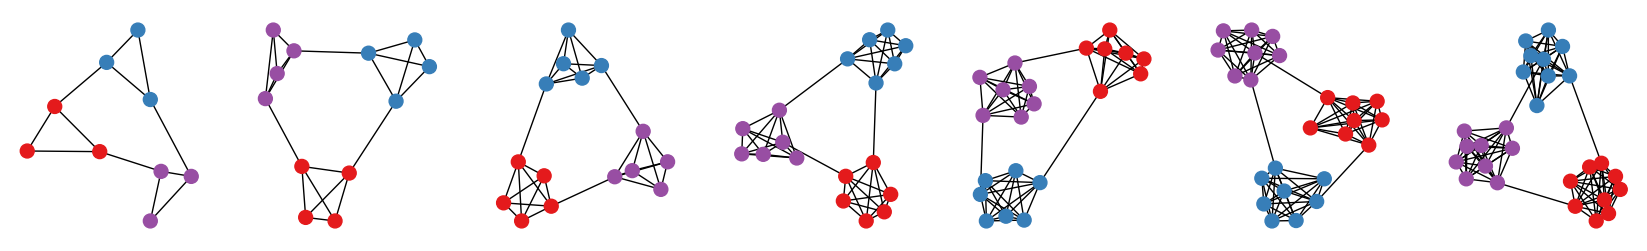

In [12]:
nodes_per_comms_s = range(3, 10)
labels = False

fig, ax = plt.subplots(1, len(nodes_per_comms_s), figsize=(3*len(nodes_per_comms_s), 3))

for i, nodes in enumerate(nodes_per_comms_s):

    G = utils.make_community_graph(n_comms=3, nodes_per_comm=nodes)
    
    pos = nx.spring_layout(G, k=0.9)

    # colour nodes by community, with desaturation
    comms = [0]*nodes + [1]*nodes + [2]*nodes
    colours = plt.cm.Set1(np.array(comms)/5)

    nx.draw(G, ax=ax[i], node_size=100, with_labels=labels, pos=pos, node_color=colours)

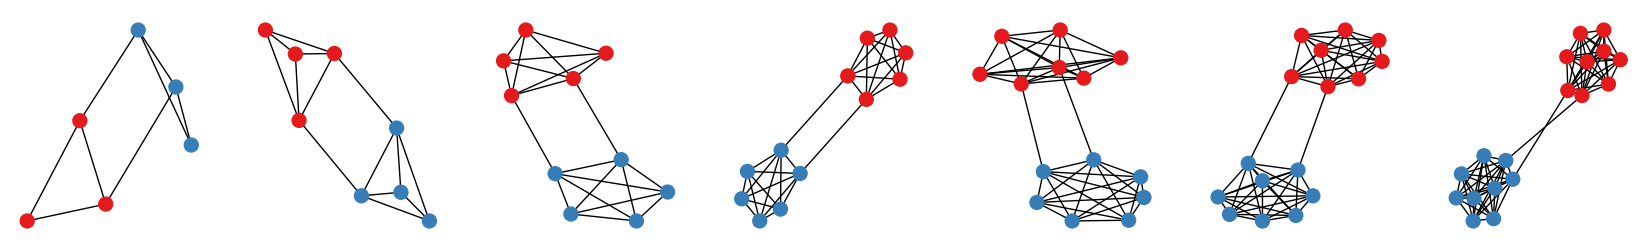

In [12]:
nodes_per_comms_s = range(3, 10)
labels = False

fig, ax = plt.subplots(1, len(nodes_per_comms_s), figsize=(3*len(nodes_per_comms_s), 3))

for i, nodes in enumerate(nodes_per_comms_s):

    G = utils.make_community_graph(n_comms=2, nodes_per_comm=nodes)
    
    pos = nx.spring_layout(G, k=0.9)

    # colour nodes by community, with desaturation
    comms = [0]*nodes + [1]*nodes
    colours = plt.cm.Set1(np.array(comms)/5)

    nx.draw(G, ax=ax[i], node_size=100, with_labels=labels, pos=pos, node_color=colours)

In [2]:
polarization_metrics = [nvd.pairwise_average, nvd.avg_dist_to_mean, nvd.PCA_manifold, nvd.MDS_euclidean_manifold, nvd.total_variation]
metric_names = ['Avg pairwise dist', 'Avg dist to mean', 'PCA', 'Euclidean MDS', 'Total variation']
random_run_metrics = {'PCA', 'Euclidean MDS'}

## Adding orthogonally opinionated nodes

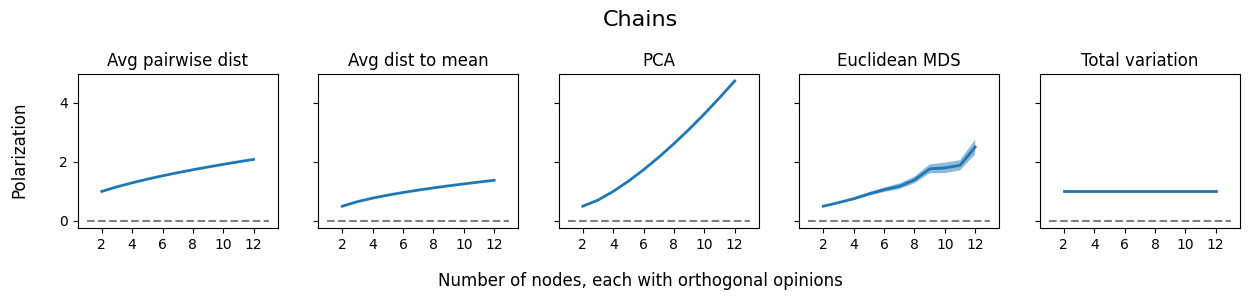

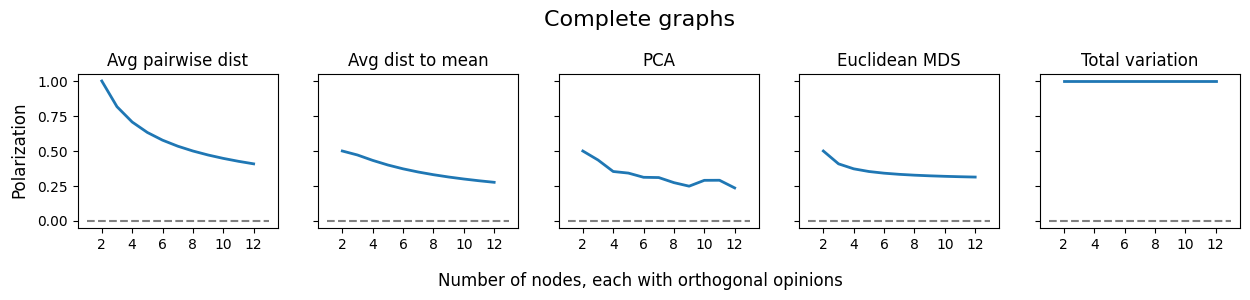

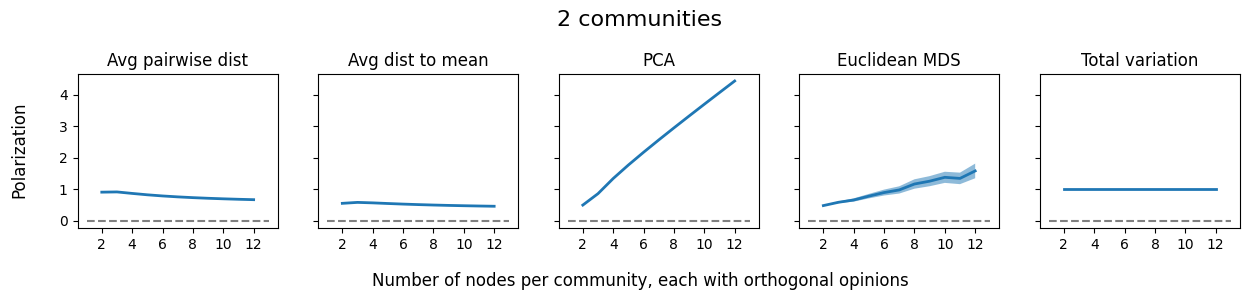

In [18]:
num_opinions_range = range(2, 13)
num_runs = 100

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('2 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_opinions_range))
        lower_confs = np.zeros(len(num_opinions_range))
        higher_confs = np.zeros(len(num_opinions_range))

        for opinion_index, num_opinions in enumerate(num_opinions_range):

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=2, nodes_per_comm=num_opinions)
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions*2)], data=np.identity(num_opinions*2))
                else:
                    G = graph_type(num_opinions)
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))

                
                tensor = nvd.make_tensor(G, o)
                polarization = polarization_metric(tensor)
                run_pols[run] = polarization

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_opinions_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_opinions_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_opinions_range[0]-1, xmax=num_opinions_range[-1]+1, colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_opinions_range
        ax[i].set_xticks([num for num in num_opinions_range if num % 2 == 0])

    if graph_name == '2 communities':
        fig.supxlabel('Number of nodes per community, each with orthogonal opinions', y=-0.2)
    else:
        fig.supxlabel('Number of nodes, each with orthogonal opinions', y=-0.2)
    fig.supylabel('Polarization', x=0.08)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

## Converting neutral community to third orthogonal opinion

### In chains

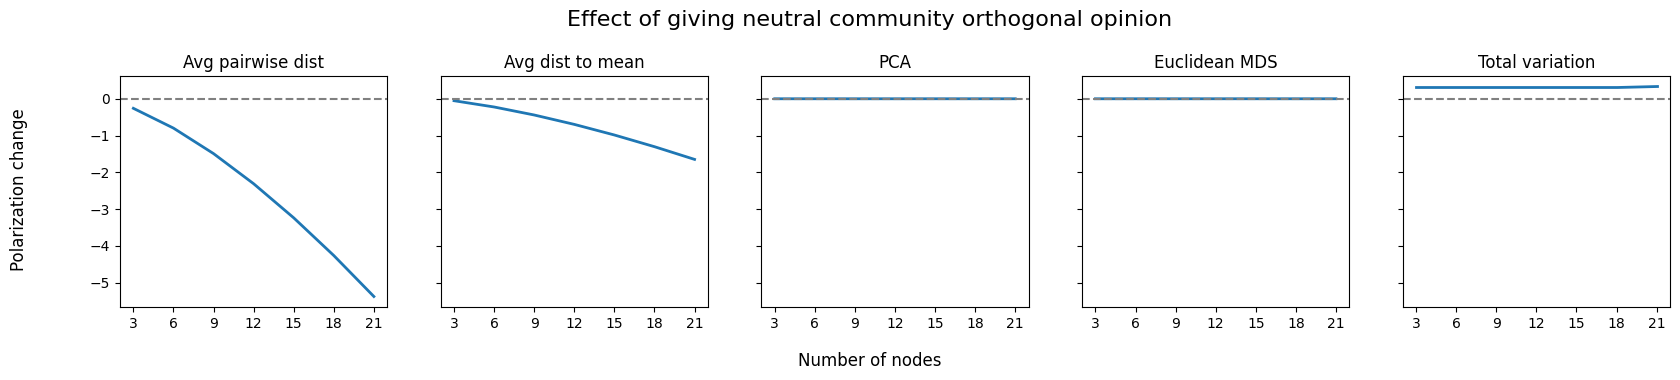

In [26]:
num_nodes_range = range(3, 22, 3)
assert all([num_nodes % 3 == 0 for num_nodes in num_nodes_range]), f'num_nodes not divisible by 3'

opinion_types = ['neutral', 'third opinion']

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    means_diffs = np.array([])

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        neutral_polarization = 0
        third_polarization = 0
        
        # Generating G as chain graph
        G = nx.path_graph(num_nodes)

        # neutral opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                            np.array([(0,0)]*nodes_per_comm),
                                                            np.array([(0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        neutral_polarization = polarization_metric(tensor)

        # third opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                    np.array([(0,1,0)]*nodes_per_comm),
                                                                    np.array([(0,0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        third_polarization = polarization_metric(tensor)

        difference = third_polarization - neutral_polarization
        
        means_diffs = np.append(means_diffs, difference)
        
        # Print before and after polarizations for num_nodes == 3
        # if num_nodes == 3:
        #     print(f"{metric_name}: {neutral_polarization:.2f} -> {third_polarization:.2f}")                                                 

    ax[i].plot(num_nodes_range, means_diffs, lw=2)

    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

fig.supxlabel('Number of nodes', y=-0.1)
fig.supylabel('Polarization change', x=0.07)
fig.suptitle('Effect of giving neutral community orthogonal opinion', y=1.1, fontsize=16);

### In complete graphs

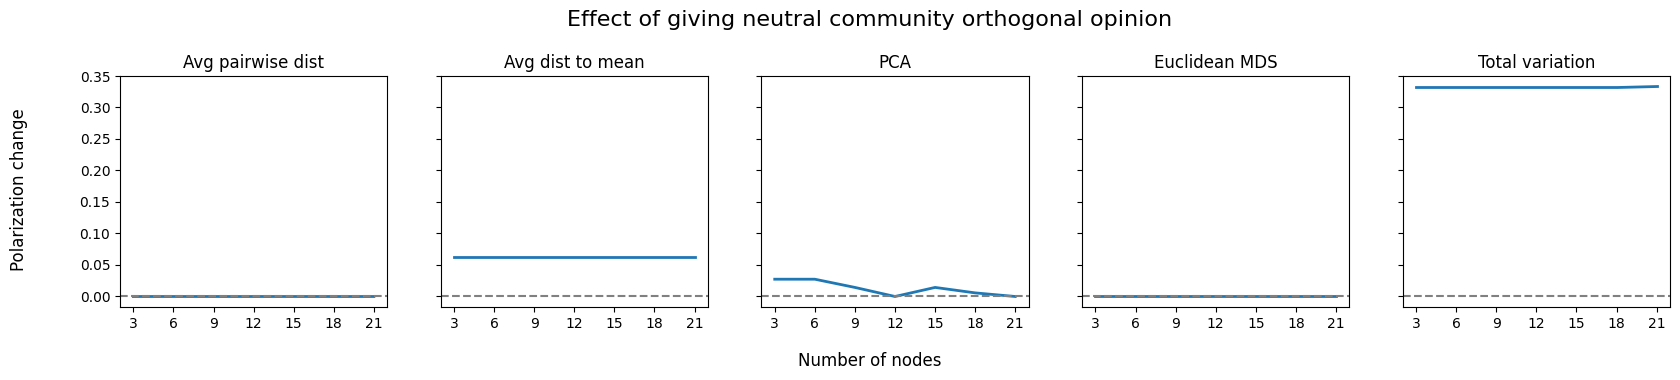

In [27]:
num_nodes_range = range(3, 22, 3)
assert all([num_nodes % 3 == 0 for num_nodes in num_nodes_range]), f'num_nodes not divisible by 3'

opinion_types = ['neutral', 'third opinion']

num_runs = 20

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    means_diffs = np.array([])

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        neutral_polarization = 0
        third_polarization = 0
        
        # Generating G as complete graph
        G = nx.complete_graph(num_nodes)

        # neutral opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                            np.array([(0,0)]*nodes_per_comm),
                                                            np.array([(0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        neutral_polarization = polarization_metric(tensor)

        # third opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                    np.array([(0,1,0)]*nodes_per_comm),
                                                                    np.array([(0,0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        third_polarization = polarization_metric(tensor)

        # Print before and after polarizations for num_nodes == 3
        # if num_nodes == 3:
        #     print(f"{metric_name}: {neutral_polarization:.2f} -> {third_polarization:.2f}")

        difference = third_polarization - neutral_polarization
        
        means_diffs = np.append(means_diffs, difference)                                                 

    ax[i].plot(num_nodes_range, means_diffs, lw=2)

    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

fig.supxlabel('Number of nodes', y=-0.1)
fig.supylabel('Polarization change', x=0.07)
fig.suptitle('Effect of giving neutral community orthogonal opinion', y=1.1, fontsize=16);

### With 3 communities

Avg pairwise dist
Avg pairwise dist
Avg pairwise dist
Avg pairwise dist
Avg pairwise dist
Avg pairwise dist
Avg pairwise dist
Avg pairwise dist
Avg pairwise dist
Avg dist to mean
Avg dist to mean
Avg dist to mean
Avg dist to mean
Avg dist to mean
Avg dist to mean
Avg dist to mean
Avg dist to mean
Avg dist to mean
PCA
PCA
PCA
PCA
PCA
PCA
PCA
PCA
PCA
Euclidean MDS
Euclidean MDS
Euclidean MDS
Euclidean MDS
Euclidean MDS
Euclidean MDS
Euclidean MDS
Euclidean MDS
Euclidean MDS
Total variation
Total variation
Total variation
Total variation
Total variation
Total variation
Total variation
Total variation
Total variation


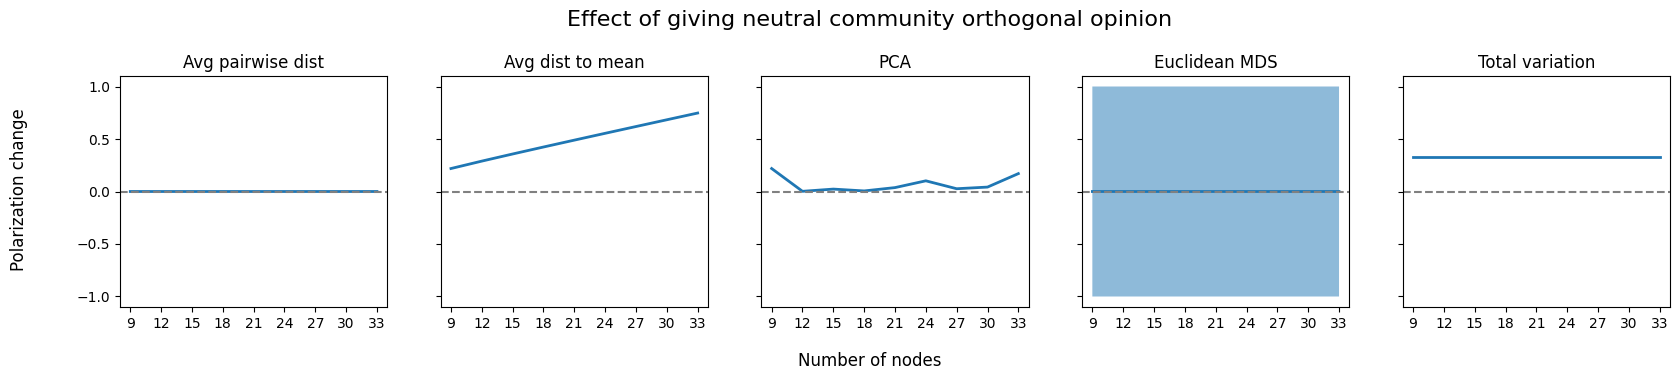

In [47]:
num_nodes_range = range(9, 34, 3)

num_runs = 5

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for metric_index, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    means_diffs = np.zeros(len(num_nodes_range))
    pol_lower_conf = np.zeros(len(num_nodes_range))
    pol_higher_conf = np.zeros(len(num_nodes_range))

    for node_count_index, num_nodes in enumerate(num_nodes_range):

        run_diffs = np.zeros(num_runs)
        
        for run in range(num_runs):

            nodes_per_comm = num_nodes//3
        
            neutral_polarization = 0
            third_polarization = 0
            
            # Generating G with SBM
            G = utils.make_community_graph(n_comms=3, nodes_per_comm=nodes_per_comm)

            # neutral opinion polarization
            o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                                np.array([(0,0)]*nodes_per_comm),
                                                                np.array([(0,1)]*nodes_per_comm))))
            tensor = nvd.make_tensor(G, o)
            neutral_polarization = polarization_metric(tensor)

            # third opinion polarization
            o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))
            tensor = nvd.make_tensor(G, o)
            third_polarization = polarization_metric(tensor)

            difference = third_polarization - neutral_polarization
            run_diffs[run] = difference

        means_diffs[node_count_index] = np.mean(run_diffs)

        # Calculate the 95% confidence intervals
        # ignoring scipy RuntimeWarning: invalid value encountered in multiply
        with np.errstate(invalid='ignore'):
            lower_conf, higher_conf = st.t.interval(0.95, len(run_diffs)-1, loc=np.mean(run_diffs), scale=st.sem(run_diffs))
        pol_lower_conf[node_count_index] = lower_conf
        pol_higher_conf[node_count_index] = higher_conf
                                                    
    ax[metric_index].plot(num_nodes_range, means_diffs, lw=2)
    ax[metric_index].fill_between(num_nodes_range, pol_higher_conf+1, pol_lower_conf-1, alpha=.5, linewidth=0)

    ax[metric_index].set_xticks(num_nodes_range)
    ax[metric_index].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[metric_index].set_title(metric_name)
    ax[metric_index].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

fig.supxlabel('Number of nodes', y=-0.1)
fig.supylabel('Polarization change', x=0.07)
fig.suptitle('Effect of giving neutral community orthogonal opinion', y=1.1, fontsize=16);

# Q: why are the confidence intervals only displayed for Euclidean MDS?
# A: because the other metrics are not defined for the 3rd opinion

 

## Duplicating one or more opinion vectors

Note: for some reason it makes no difference whether I duplicate one or 3 opinions, is it a bug?

### On chain graphs

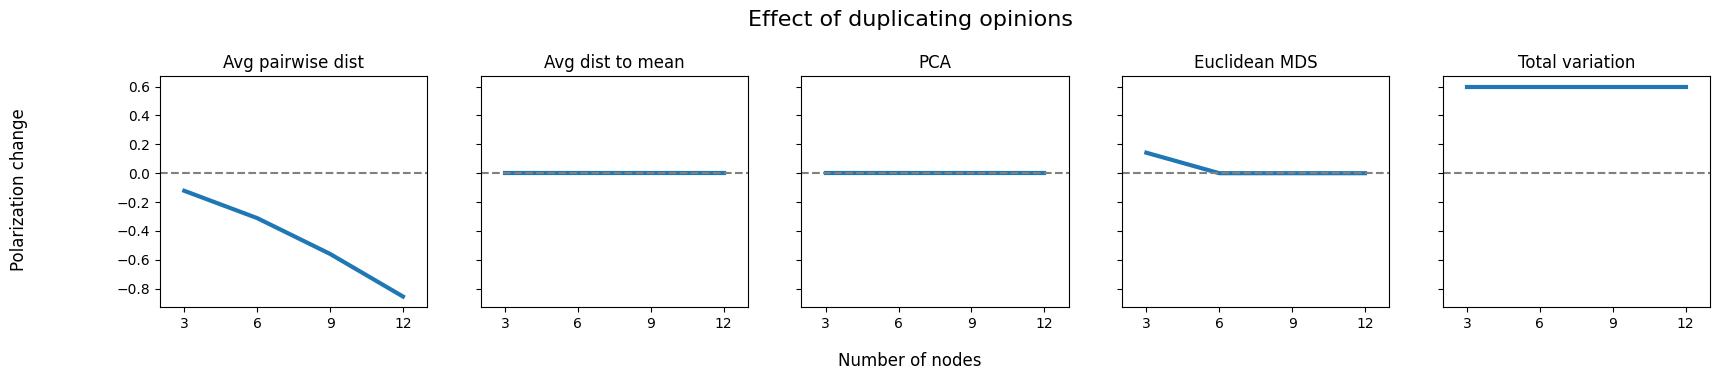

In [19]:
num_nodes_range = range(3, 13, 3)

assert all([num_nodes % 3 == 0 for num_nodes in num_nodes_range]), f'num_nodes not divisible by 3'

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    unique_polarizations = []
    duplicate_polarizations = []
    differences = []

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        unique_polarization = 0
        duplicate_polarization = 0
        
        G = nx.path_graph(num_nodes)

        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

        tensor = nvd.make_tensor(G, o)
        unique_polarization = polarization_metric(tensor)

        # duplicate last column of o
        dup_o = pd.concat([o, o], axis=1)
        # dup_o.columns = ['o0', 'o1', 'o2', 'o3']
        
        dup_tensor = nvd.make_tensor(G, dup_o)
        duplicate_polarization = polarization_metric(dup_tensor)

        difference = duplicate_polarization - unique_polarization
        differences.append(difference)
        unique_polarizations.append(unique_polarization)
        duplicate_polarizations.append(duplicate_polarization)

    ax[i].plot(num_nodes_range, differences, lw=3)
    # ax[i].plot(num_nodes_range, unique_polarizations, lw=2, color='C0')
    # ax[i].plot(num_nodes_range, duplicate_polarizations, lw=2, color='C1')
    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

    fig.supxlabel('Number of nodes', y=-0.1)
    fig.supylabel('Polarization change', x=0.05)
    fig.suptitle(f'Effect of duplicating opinions', y=1.1, fontsize=16);

### On complete graphs

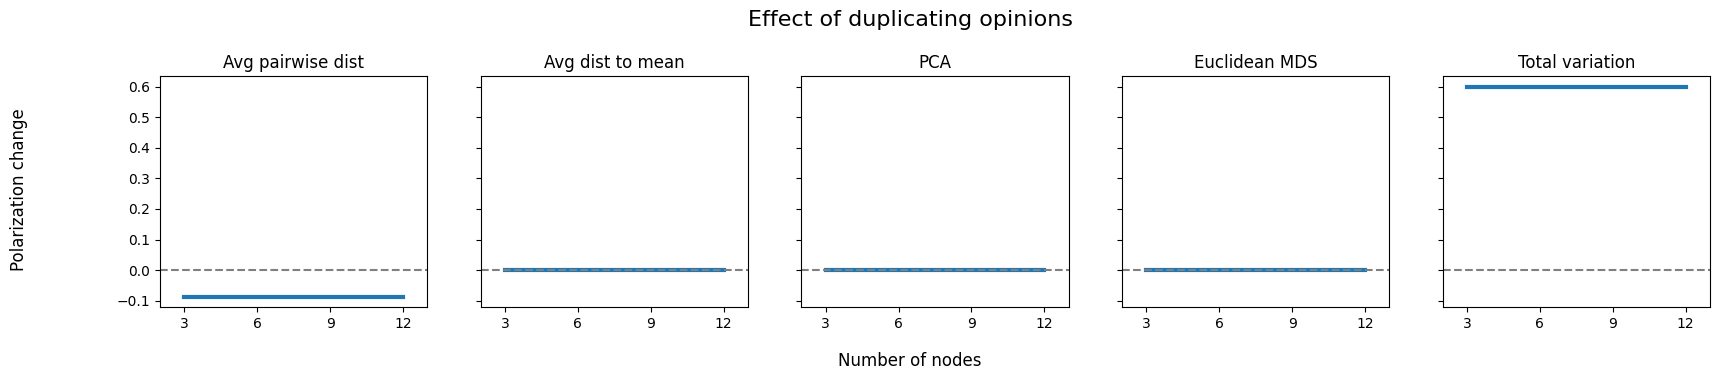

In [20]:
num_nodes_range = range(3, 13, 3)

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    differences = []

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        unique_polarization = 0
        duplicate_polarization = 0
        
        G = nx.complete_graph(num_nodes)

        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

        tensor = nvd.make_tensor(G, o)
        unique_polarization = polarization_metric(tensor)

        # duplicate last column of o
        dup_o = pd.concat([o, o], axis=1)
        # dup_o.columns = ['o0', 'o1', 'o2', 'o3']
        
        dup_tensor = nvd.make_tensor(G, dup_o)
        duplicate_polarization = polarization_metric(dup_tensor)

        difference = duplicate_polarization - unique_polarization
        differences.append(difference)

    ax[i].plot(num_nodes_range, differences, lw=3)
    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

    fig.supxlabel('Number of nodes', y=-0.1)
    fig.supylabel('Polarization change', x=0.05)
    fig.suptitle(f'Effect of duplicating opinions', y=1.1, fontsize=16);

### On SBM network with 3 communities, p_out=0.1

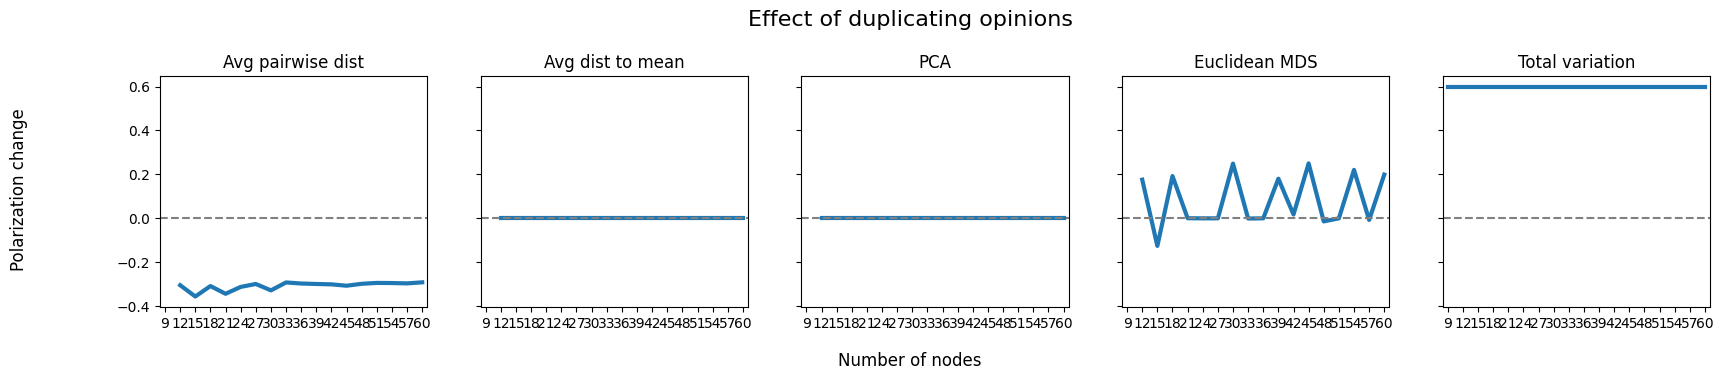

In [21]:
num_nodes_range = range(9, 63, 3)

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    differences = []

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        unique_polarization = 0
        duplicate_polarization = 0
        
        G = SBM_graph(n_comms=3, p_out=0.1, intercon=2, nodes_per_comm=nodes_per_comm)

        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

        tensor = nvd.make_tensor(G, o)
        unique_polarization = polarization_metric(tensor)

        # duplicate last column of o
        dup_o = pd.concat([o, o], axis=1)
        # dup_o.columns = ['o0', 'o1', 'o2', 'o3']
        
        dup_tensor = nvd.make_tensor(G, dup_o)
        duplicate_polarization = polarization_metric(dup_tensor)

        difference = duplicate_polarization - unique_polarization
        differences.append(difference)

    ax[i].plot(num_nodes_range, differences, lw=3)
    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

    fig.supxlabel('Number of nodes', y=-0.1)
    fig.supylabel('Polarization change', x=0.05)
    fig.suptitle(f'Effect of duplicating opinions', y=1.1, fontsize=16);

In [22]:
def plot_test(num_opinions_range, n_nodes, n_comms, p_out, intercon, polarization_metrics, metric_names, plot_title, plot_xlabel, plot_ylabel, opinion_type, num_runs=10):
    """
    Plot the polarization of a SBM graph with different number of opinions and different polarization metrics.
    
    num_opinions_range: range, range of number of opinions to test
    num_runs: int, number of runs random initializations for each test
    opinion_types: list, list of opinion types to test
    """

    if not n_nodes % n_comms == 0:
        raise ValueError(f'n_nodes={n_nodes} not divisible by n_comms={n_comms}')
    nodes_per_comm = n_nodes//n_comms

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        pols = np.array([])
        pol_lower_conf = np.array([])
        pol_higher_conf = np.array([])

        for num_opinions in num_opinions_range:

            run_pols = np.zeros(num_runs)

            for run in range(num_runs):

                G = SBM_graph(n_nodes, n_comms, p_out, intercon, nodes_per_comm)
    

                if opinion_type == 'unique':
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))
                elif opinion_type == 'orthogonal':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                                np.array([(0,1,0)]*nodes_per_comm),
                                                                                np.array([(0,0,1)]*nodes_per_comm))))
                elif opinion_type == 'correlated':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,1,0)]*nodes_per_comm),
                                                                                np.array([(0,1,1)]*nodes_per_comm),
                                                                                np.array([(1,0,1)]*nodes_per_comm))))
                else:
                    raise ValueError(f'opinion_type={opinion_type} not valid. Must be one of "unique", "orthogonal", "correlated".')

                tensor = nvd.make_tensor(G, o)
                Linv = nvd._Linv(tensor)

                polarization = polarization_metric(tensor, Linv=Linv)
                run_pols[run] = polarization

            # Calculate the mean polarization of num_runs runs
            pols = np.append(pols, np.mean(run_pols))  

            # Calculate the 95% confidence intervals of the mean polarization
            lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))
            pol_lower_conf = np.append(pol_lower_conf, lower_conf)
            pol_higher_conf = np.append(pol_higher_conf, higher_conf)

        ax[i].plot(num_opinions_range, pols, lw=2)
        ax[i].fill_between(num_opinions_range, pol_higher_conf, pol_lower_conf, alpha=.5, linewidth=0)  # Shade the 95% confidence interval around the mean
        ax[i].set_title(metric_name)

    fig.suptitle(plot_title, y=1.1, fontsize=16)
    fig.supxlabel(plot_xlabel, y=-0.1)
    fig.supylabel(plot_ylabel, x=0.05);